# Imports

In [1]:
from collections import OrderedDict
from pathlib import Path
from warnings import warn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.cosmology import WMAP9 as wmap9
from matplotlib.ticker import MultipleLocator
from scipy.stats.stats import pearsonr
from sndata.csp import DR3
from sndata.sdss import Sako18Spec
from sndata.utils import convert_to_jd

from utils import read_in_pipeline_result, proposed_cutoff, feature_alias


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: TableReplaceWarning: converted column 'ndofSALT2zspec' from integer to float
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: TableReplaceWarning: converted column 'ndofMLCS2k2zspec' from integer to float
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: TableReplaceWarning: converted column 'lcqualityIaPSNIDzspec' from integer to float
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: TableReplaceWarning: converted column 'lcqualityIbcPSNIDzspec' from integer to float
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: TableReplaceWarning: converted column 'lcqualityIIPSNIDzspec' from integer to float
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-package

In [2]:
DR3().download_module_data()
Sako18Spec().download_module_data()


In [3]:
results_dir = Path('.').resolve() .parent / 'results'
sdss_final = read_in_pipeline_result(results_dir / 'final_sdss.csv', 'sdss', drop_flagged=True)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TableReplaceWarning: converted column 'ndofSALT2zspec' from integer to float
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TableReplaceWarning: converted column 'ndofMLCS2k2zspec' from integer to float
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TableReplaceWarning: converted column 'lcqualityIaPSNIDzspec' from integer to float
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TableReplaceWarning: converted column 'lcqualityIbcPSNIDzspec' from integer to float
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TableReplaceWarning: converted column 'lcqualityIIPSNIDzspec' from integer to float
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TableReplaceWarning: converted column 'NnnPSNIDzspec' from integer to float
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TableReplaceWarning: 

# Functions

In [4]:
def create_corner_hist_figure(
    num_subfigs=8, subfigs_per_row=2, fig_size=(6.5, 9), xlabel=None, ylabel=None, vspace=.15, hspace=.15
):
    """Create a figure containing axes for multiple scatter plots with bordering histograms
    
    Args:
        num_subfigs     (int): Number of axes to make for scatter plots
        subfigs_per_row (int): Number of Scatter plot axes per row
        fig_size      (Tuple): The size of the figure
        x_label         (str): x-label to use for the figure
        ylabel          (str): y-label to use for the figure
        
    Returns:
        The matplolib figure
        An array of axes for scatter plots
        An array of axes for x-axis histograms
        An array of axes for y-axis histograms
    """
    
    # Calculate the number and relative width of each column
    columns_per_feature = 3
    num_columns = (subfigs_per_row * columns_per_feature) - 1

    histogram_width = .5
    width_ratios = np.ones(num_columns)
    width_ratios[2::3] = hspace
    width_ratios[1::3] = histogram_width
    width_ratios /= sum(width_ratios)

    # Calculate the number and relative height of each row
    rows_per_feature = 3
    num_rows = int(np.ceil(num_subfigs / subfigs_per_row * rows_per_feature)) - 1

    spacer_height = .15
    histogram_height = .5
    height_ratios = np.ones(num_rows)
    height_ratios[0::3] = histogram_height
    height_ratios[2::3] = vspace
    height_ratios /= sum(height_ratios)

    # Create all subplots. We'll go in and hide the spacer subplots after
    fig, axes = plt.subplots(
        num_rows, num_columns,
        figsize=fig_size,
        gridspec_kw={'width_ratios': width_ratios, 'height_ratios': height_ratios, 'hspace': 0, 'wspace': 0})

    # Hide spacer columns
    for axis in axes[:, 2::columns_per_feature].flatten():
        axis.set_visible(False)

    # Hide spacer rows
    for axis in axes[2::rows_per_feature].flatten():
        axis.set_visible(False)

    # Hide axes in the corner formed by histogram subplots
    for axis in axes[0::rows_per_feature, 1::columns_per_feature].flatten():
        axis.set_visible(False)

    scatter_axes = axes[1::rows_per_feature, 0::columns_per_feature].flatten()
    vertical_hist = axes[1::rows_per_feature, 1::columns_per_feature].flatten()
    horizontal_hist = axes[0::rows_per_feature, 0::columns_per_feature].flatten()
    for sax, vax, hax in zip(scatter_axes, vertical_hist, horizontal_hist):
        sax.sharex = hax 
        sax.sharey = vax 
        
    # Assign labels
    for axis in axes[1::rows_per_feature, 0].flatten():
        axis.set_ylabel(ylabel)
        
    for axis in axes[-1, 0::columns_per_feature].flatten():
        axis.set_xlabel(xlabel)
        
    
    return fig, scatter_axes, horizontal_hist, vertical_hist


In [5]:
def plot_scatter_hist(data, features, xcol, ycol, yerrcol=None, xlabel=None, ylabel=None, figsize=None):
    """Create scatter plots with bordering histograms
    
    One scatter plot is created for each of the specified features
    
    Args:
        data     (DataFrame): The data to plot
        features (List[str]): The feature ids to plot
        xcol           (str): Name of the column to plot along the x-axis
        ycol           (str): Name of the column to plot along the y-axis
        xlabel         (str): Optional x label (defaults to same value as xcol)
        ylabel         (str): Optional x label (defaults to same value as ycol)
    """
    
    fig, *axes = create_corner_hist_figure(
        num_subfigs = len(features), 
        fig_size=figsize or (10, 20),
        vspace=.2,
        xlabel=xcol if xlabel is None else xlabel,
        ylabel=ycol if ylabel is None else ylabel
    )
    
    # Create a copy of the plotting data with a new column for the color of the plotted data
    color_mapping = dict(BL='red', SS='green', CL='blue', CN='black', unknown='grey')
    color_data = data.copy()
    color_data['color'] = color_data['branch_type'].fillna('unknown').map(color_mapping)

    for feat, scatter_ax, horizontal_ax, vertical_ax in zip(features, *axes):
        feat_data = color_data.loc[feat]
        x = feat_data[xcol]
        y = feat_data[ycol]
        c = feat_data['color']
        
        scatter_ax.scatter(x, y, s=8, c=c, alpha=0.7)
        horizontal_ax.hist(x)
        vertical_ax.hist(y, orientation='horizontal')
        if yerrcol:
            scatter_ax.errorbar(x, y, feat_data[yerrcol], linestyle='', ecolor=c, alpha = 0.3)
         
        # To do a stacked histogram, use:
        #hist_data = feat_data.reset_index().pivot(columns='branch_type')
        #hist_data[xcol].plot(kind='hist', ax=horizontal_ax, stacked=True, legend=False)
        #hist_data[ycol].plot(kind='hist', ax=vertical_ax, stacked=True, legend=False, orientation='horizontal')
            

# x0

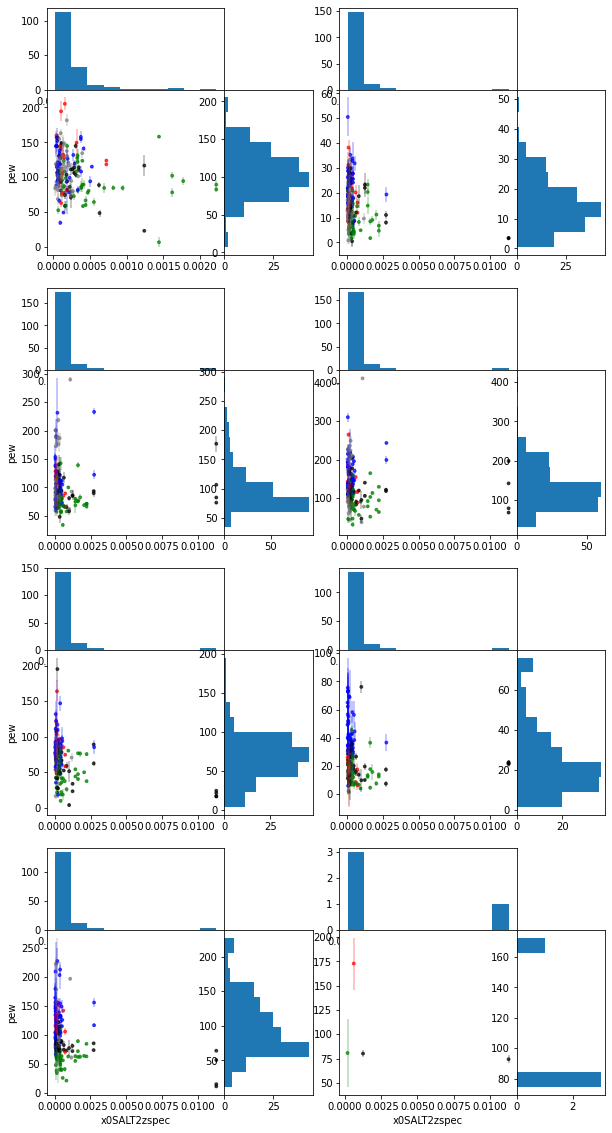

In [6]:
# pew
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_final, 
    features, 
    'x0SALT2zspec', 
    'pew', 
    'pew_samperr')


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/anaconda3/lib/python3.7/site-pac

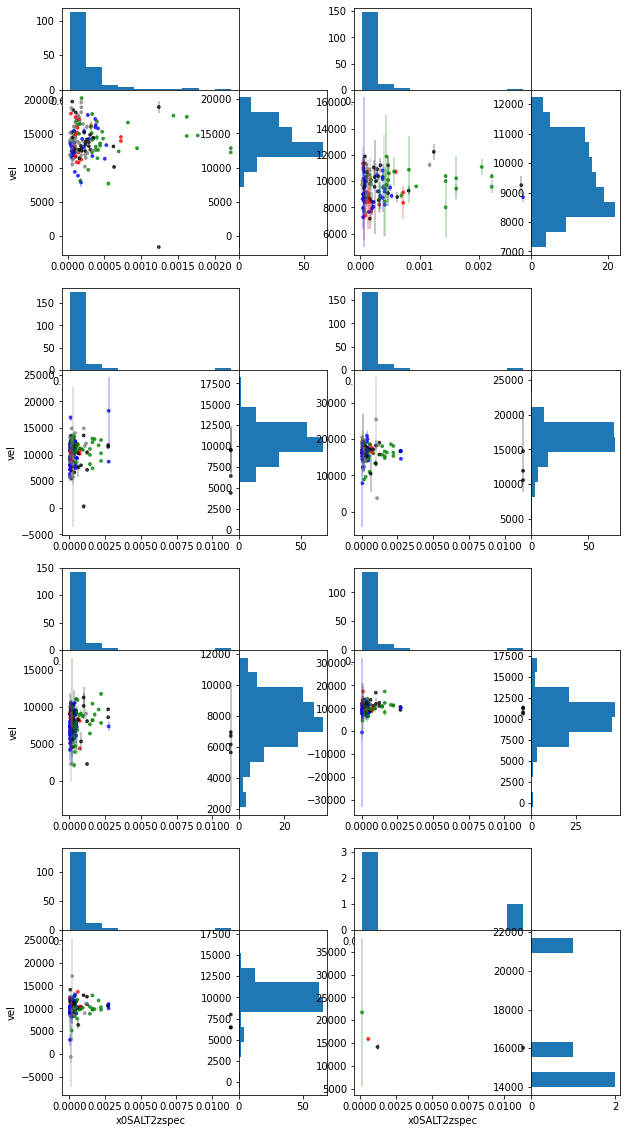

In [7]:
# velocity
plot_scatter_hist(
    sdss_final, 
    features, 
    'x0SALT2zspec', 
    'vel', 
    'vel_samperr')


# x1

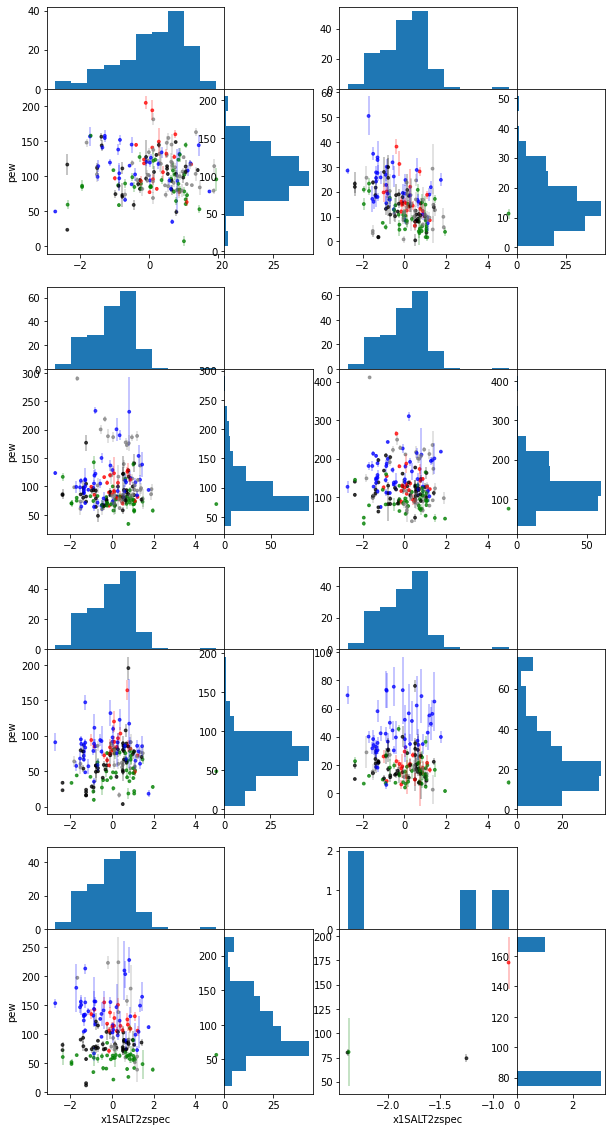

In [8]:
# pew
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_final, 
    features, 
    'x1SALT2zspec', 
    'pew', 
    'pew_samperr')


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/anaconda3/lib/python3.7/site-pac

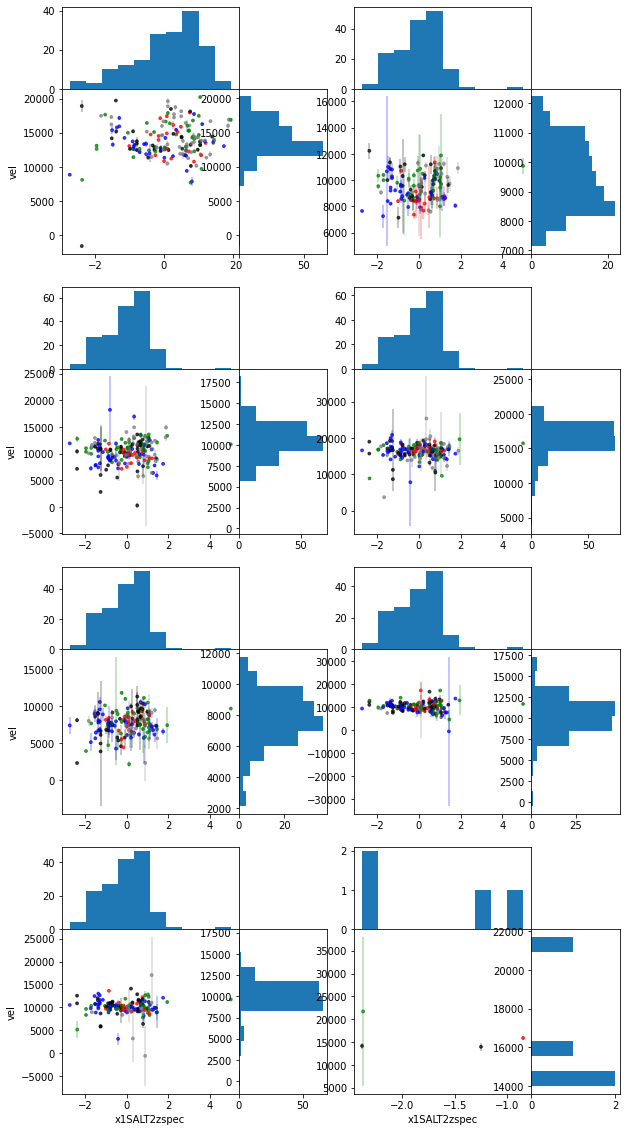

In [9]:
# vel
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_final, 
    features, 
    'x1SALT2zspec', 
    'vel', 
    'vel_samperr')


# Color

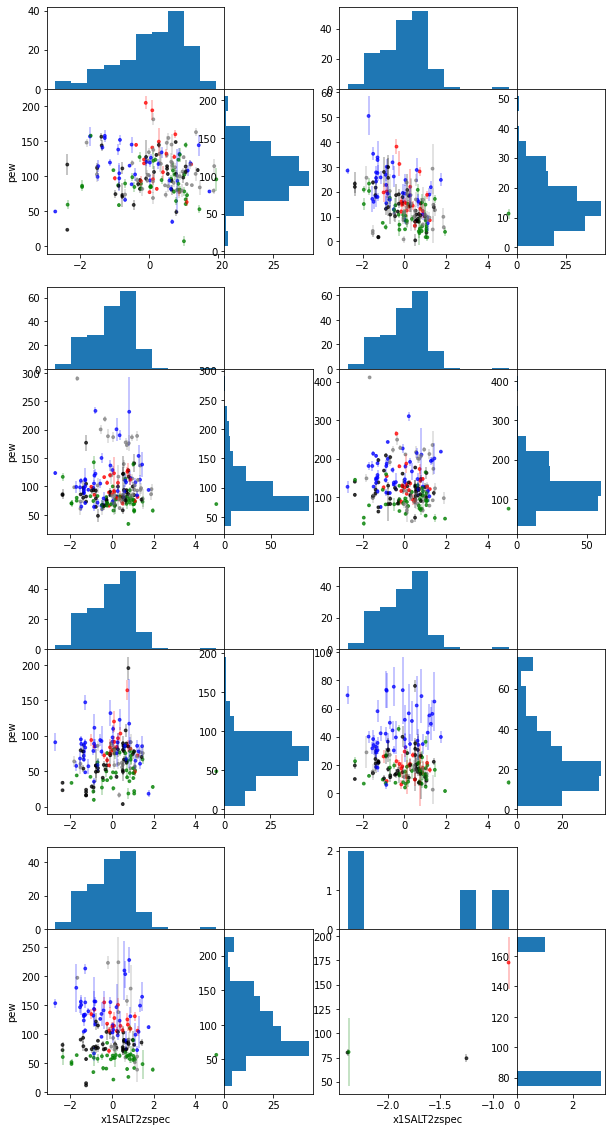

In [10]:
# pew
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_final, 
    features, 
    'x1SALT2zspec', 
    'pew', 
    'pew_samperr')


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/anaconda3/lib/python3.7/site-pac

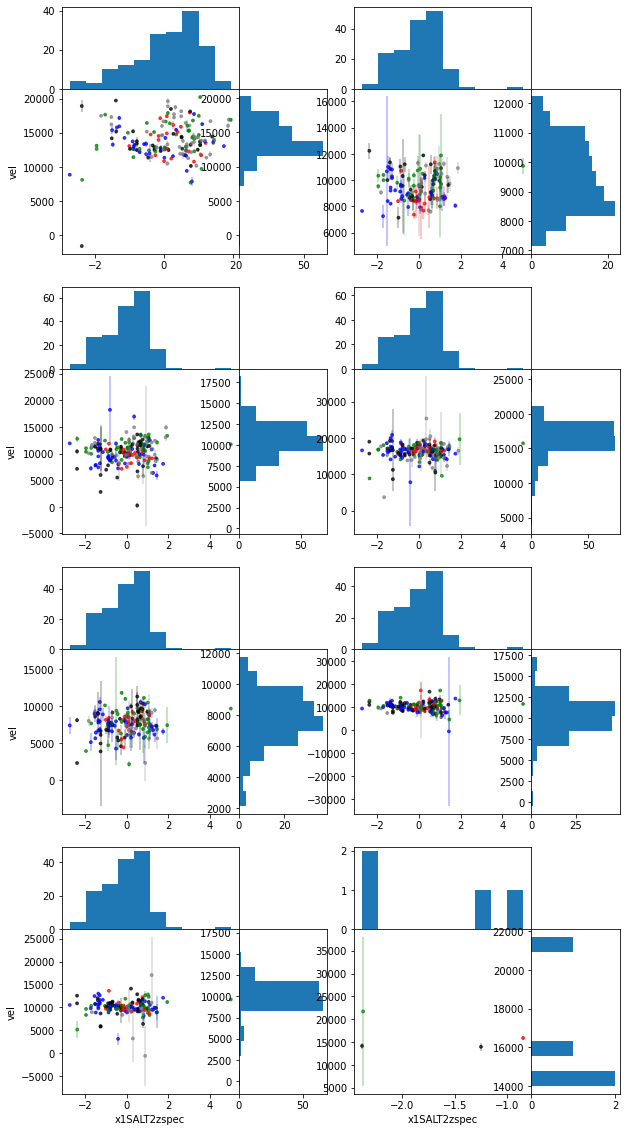

In [11]:
# vel
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_final, 
    features, 
    'x1SALT2zspec', 
    'vel', 
    'vel_samperr')
